# Insurance Cost Prediction Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# 1. Data Loading and Exploration

In [2]:
df = pd.read_csv('insurance.csv')
print("First 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Basic statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.

# 2. Data Preprocessing

In [3]:
# Encode categorical variables
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['region'] = le.fit_transform(df['region'])

# Features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Exploratory Data Analysis

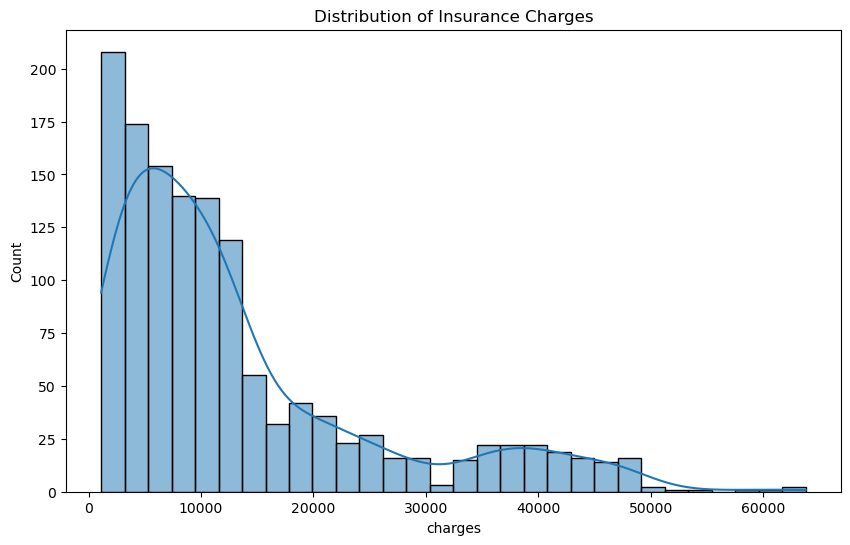

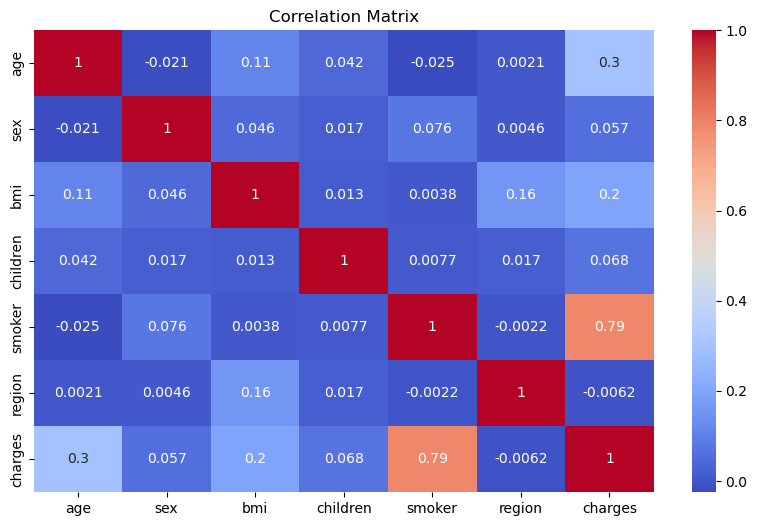

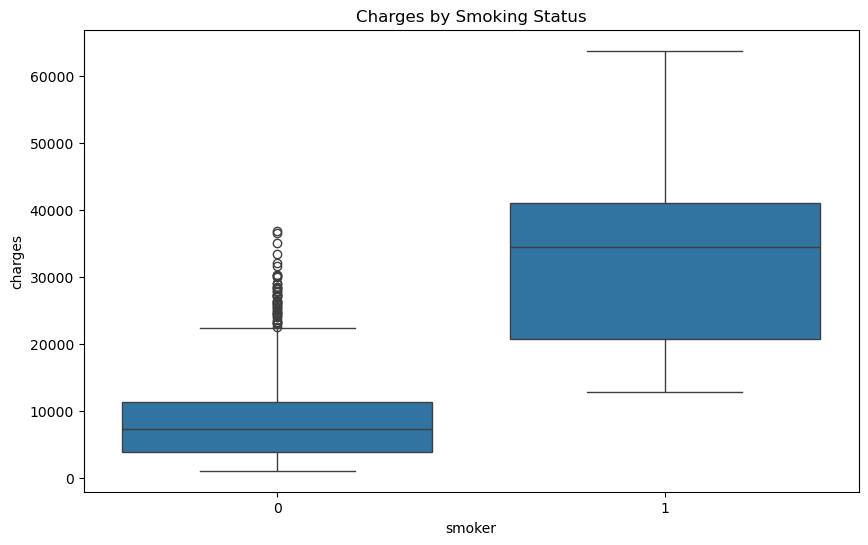

In [4]:
# Distribution of charges
plt.figure(figsize=(10,6))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.savefig('charges_dist.png')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_heatmap.png')
plt.show()

# Boxplot for smoker vs charges
plt.figure(figsize=(10,6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoking Status')
plt.savefig('smoker_boxplot.png')
plt.show()

# 4. Feature Engineering

In [5]:
# Feature Engineering
# BMI categories
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])

# Age bins
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])

# Encode new features
le = LabelEncoder()
df['bmi_category'] = le.fit_transform(df['bmi_category'])
df['age_group'] = le.fit_transform(df['age_group'])

# Update X
X = df.drop('charges', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Model Building and Training

In [6]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

In [7]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores
cv_scores = {}
for name, model in trained_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_scores[name] = scores
    print(f'{name} CV R2: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')

Linear Regression CV R2: 0.738 (+/- 0.097)
Decision Tree CV R2: 0.715 (+/- 0.148)
Random Forest CV R2: 0.825 (+/- 0.085)
Random Forest CV R2: 0.825 (+/- 0.085)


In [8]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

# Use best model
best_rf = grid_search.best_estimator_
trained_models['Tuned Random Forest'] = best_rf

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best R2 score: 0.8420524642071477


# 6. Model Evaluation

In [9]:
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.2f}')

Linear Regression: RMSE=5793.74, MAE=4128.34, R2=0.78
Decision Tree: RMSE=6635.60, MAE=3027.72, R2=0.72
Random Forest: RMSE=4602.89, MAE=2550.16, R2=0.86
Tuned Random Forest: RMSE=4356.15, MAE=2445.51, R2=0.88


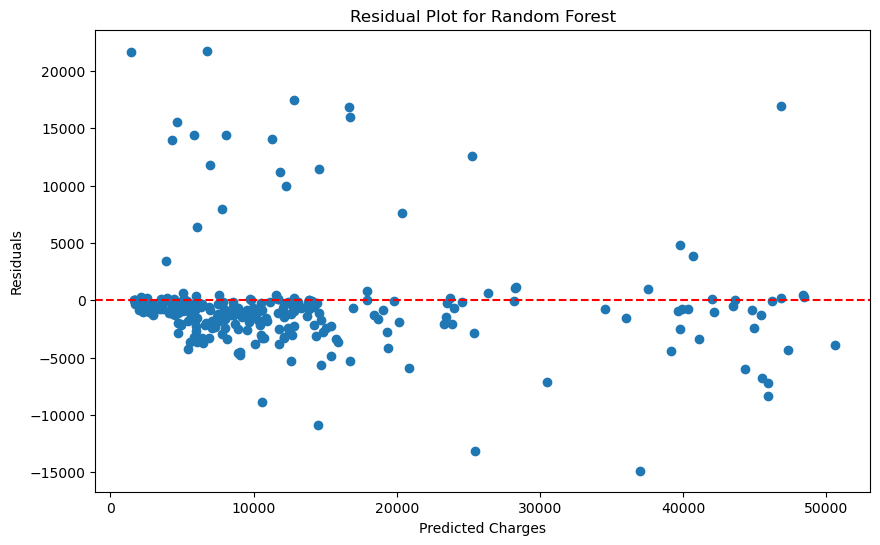

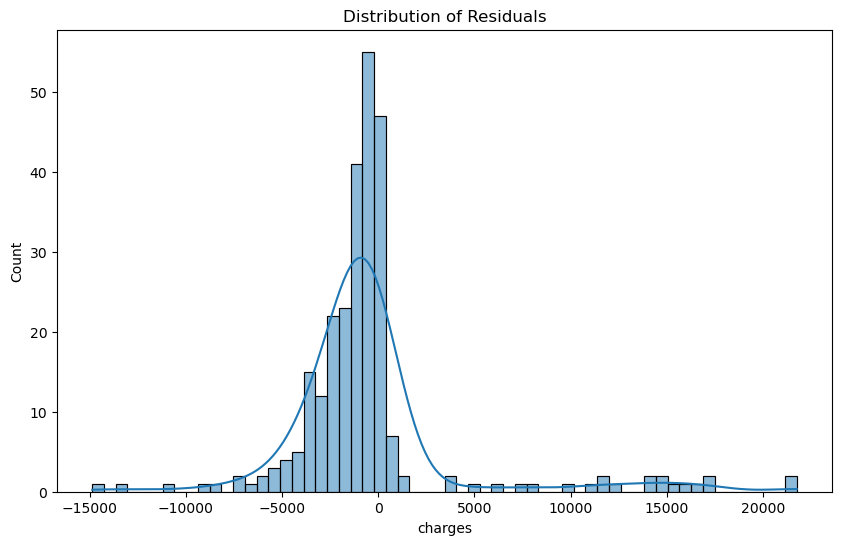

In [10]:
# Error Analysis for Random Forest
rf = trained_models['Random Forest']
y_pred_rf = rf.predict(X_test_scaled)
residuals = y_test - y_pred_rf

plt.figure(figsize=(10,6))
plt.scatter(y_pred_rf, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest')
plt.savefig('residual_plot.png')
plt.show()

# Distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.savefig('residual_dist.png')
plt.show()

# 7. Feature Importance Analysis

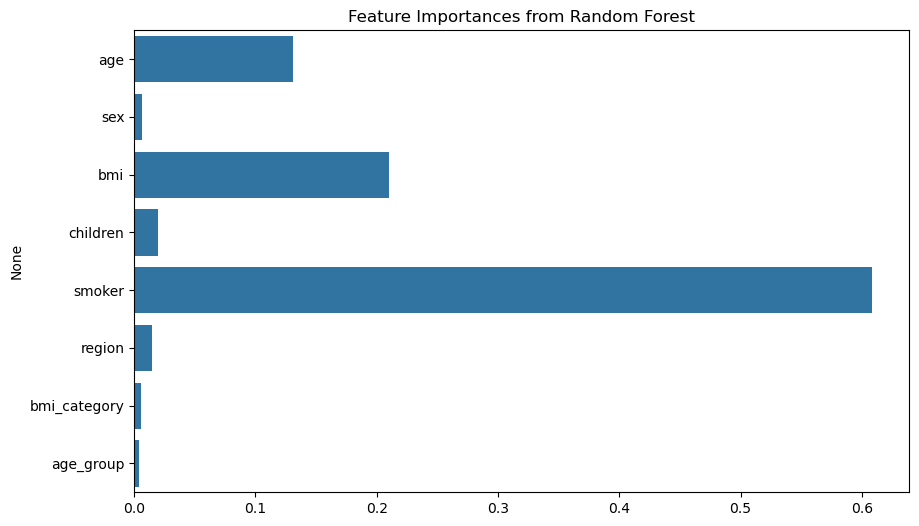

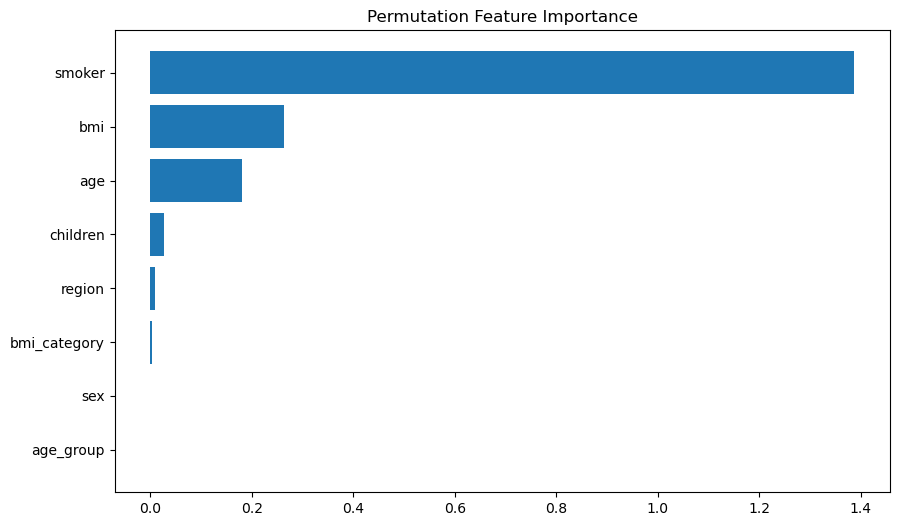

In [11]:
# For Random Forest
rf = trained_models['Random Forest']
importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances from Random Forest')
plt.show()

# Permutation importance
perm_importance = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Permutation Feature Importance')
plt.show()

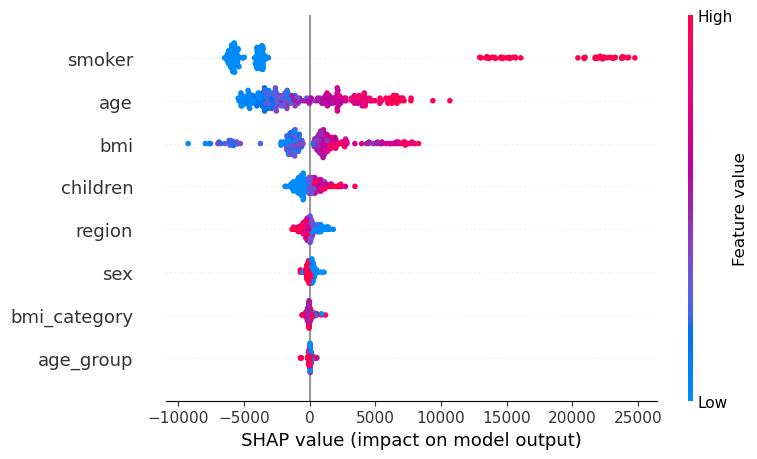

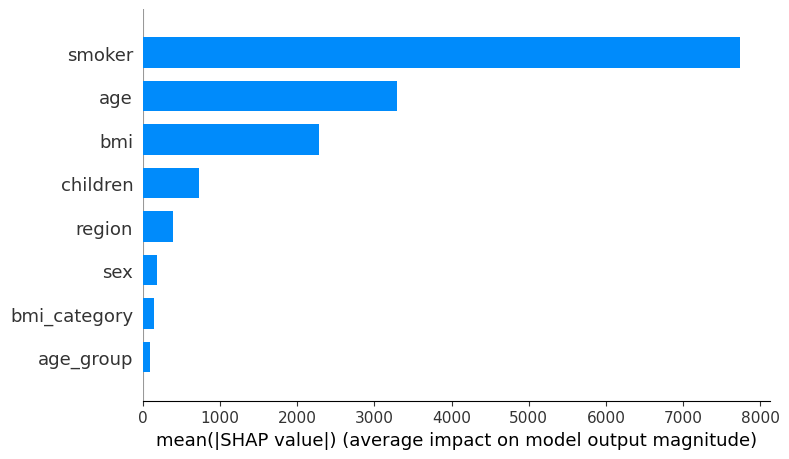

In [15]:
import shap

# SHAP for interpretability
rf = trained_models['Random Forest']
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
plt.show()

# Bar plot for feature importance
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
plt.savefig('shap_bar.png', bbox_inches='tight')
plt.show()

# 8. Fairness Assessment

In [13]:
# Actual charges by group
print("Mean charges by sex:")
print(df.groupby('sex')['charges'].mean())
print("\nMean charges by region:")
print(df.groupby('region')['charges'].mean())

# Predicted charges by group (using RF)
rf = trained_models['Random Forest']
df_test = X_test.copy()
df_test['predicted'] = rf.predict(X_test_scaled)
df_test['actual'] = y_test
print("Predicted mean by sex (encoded):")
print(df_test.groupby('sex')['predicted'].mean())

# Discuss fairness
print("Fairness concerns: Higher charges for smokers and older age are expected, but check for bias in regions or gender.")

Mean charges by sex:
sex
0    12569.578844
1    13956.751178
Name: charges, dtype: float64

Mean charges by region:
region
0    13406.384516
1    12417.575374
2    14735.411438
3    12346.937377
Name: charges, dtype: float64
Predicted mean by sex (encoded):
sex
0    12492.359102
1    14399.726738
Name: predicted, dtype: float64
Fairness concerns: Higher charges for smokers and older age are expected, but check for bias in regions or gender.
